## Cell 1 — Imports & constants

In [1]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# === LOAD TOÀN BỘ THƯ VIỆN CHO PIPELINE LIQUIDITY RISK ML ===

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

# ML core
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Resampling
from imblearn.over_sampling import SMOTE

# XAI
import shap
from lime.lime_tabular import LimeTabularExplainer

from collections import Counter
from datetime import datetime

print(" Tất cả thư viện đã import thành công!")


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
!pip install -q openpyxl imbalanced-learn shap xgboost

import os, re, unicodedata, numpy as np, pandas as pd
from typing import List

from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import BaseEstimator, TransformerMixin, clone

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import shap
import xgboost as xgb

pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42

MACRO_PATH = "Macro.xlsx"
MICRO_PATH = "Micro.xlsx"


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Cell 2 — Utils: normalize cols, percent→float

In [ ]:
def strip_accents(s: str) -> str:
    s = unicodedata.normalize('NFD', s)
    s = s.encode('ascii', 'ignore').decode('utf-8')
    return str(s)

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [re.sub(r"\s+", "_", strip_accents(str(c)).strip().lower()) for c in df.columns]
    return df

def percent_to_float(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.replace("%","", regex=False)
    s = s.str.replace(".","", regex=False)   # thousands sep
    s = s.str.replace(",",".", regex=False)  # decimal comma -> dot
    return pd.to_numeric(s, errors="coerce") / 100.0

## Cell 3 — Read & merge macro/micro

In [ ]:
macro_raw = pd.read_excel(MACRO_PATH, sheet_name="Sheet1", engine="openpyxl")
micro_raw = pd.read_excel(MICRO_PATH, sheet_name="Data", engine="openpyxl")

macro = normalize_columns(macro_raw)
micro = normalize_columns(micro_raw)

macro = macro.rename(columns={"quy_":"quy", "inf":"cpi_infl_pct", "gpd":"gdp_growth_pct", "credit":"credit_pct_gdp"})
if "quy" not in macro.columns and "quy_" in macro.columns:
    macro = macro.rename(columns={"quy_":"quy"})

for col in ["cpi_infl_pct","gdp_growth_pct","credit_pct_gdp"]:
    if col in macro.columns:
        macro[col] = percent_to_float(macro[col])

for df_ in (macro, micro):
    assert "nam" in df_.columns and "quy" in df_.columns, "Thiếu cột nam/quy"

df = micro.merge(macro[["nam","quy","cpi_infl_pct","gdp_growth_pct","credit_pct_gdp"]], on=["nam","quy"], how="left")
df = df.sort_values(["ma","nam","quy"]).reset_index(drop=True)
df.shape, df.head()

# === MERGE MICRO + MACRO ===
df = micro.merge(
    macro[["nam","quy","cpi_infl_pct","gdp_growth_pct","credit_pct_gdp"]],
    on=["nam","quy"], how="left"
)
df = df.sort_values(["ma","nam","quy"]).reset_index(drop=True)

print(" Merge hoàn tất:", df.shape)
display(df.head())

# === Lưu file output panel ===
OUTPUT_PATH = "merge.csv"
df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")
print(f" Saved merged panel to: {OUTPUT_PATH}")


 Merge hoàn tất: (1188, 15)


,ma,nam,quy,fgap,size,eta,ltd,liq,ltl,roe,npl,dta,cpi_infl_pct,gdp_growth_pct,credit_pct_gdp
0,ABB,2014,1,-0.2535,31.5619,0.1143,0.5410,0.3768,0.8505,0.0148,0.0000,0.6965,0.0483,0.0496,0.1180
1,ABB,2014,2,-0.2464,31.7167,0.0959,0.6826,0.4439,1.0992,0.0063,0.0768,0.6503,0.0498,0.0518,0.1145
2,ABB,2014,3,-0.3135,31.7031,0.0987,0.6422,0.4502,1.1617,0.0076,0.0000,0.7010,0.0225,0.0562,0.1305
3,ABB,2014,4,-0.2906,31.8426,0.0847,0.6993,0.4675,1.2371,-0.0085,0.0459,0.6685,0.0225,0.0598,0.1416
4,ABB,2015,1,-0.2803,31.7400,0.0955,0.6856,0.4508,1.1951,0.0159,NaN,NaN,0.0093,0.0603,0.1657


 Saved merged panel to: merge.csv


## Cell 4 — Label 

In [ ]:
# ===== LABEL TỪ FGAP (CHUẨN HÓA TÊN & DỊCH T+1) =====
import pandas as pd
import numpy as np

INPUT_PATH  = "merge.csv"   # file gốc
OUTPUT_PATH = "label.csv"          # file nhãn đầu ra
ID_KEYS = ["bank_id", "year", "quarter"]
TARGET  = "FGAP_stress_t+1"

# Đọc & chuẩn hóa tên cột
df = pd.read_csv(INPUT_PATH)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Đổi tên cột cho đúng chuẩn
rename_map = {
    "ma": "bank_id",
    "nam": "year",
    "quy": "quarter",
    "fgap": "FGAP",
    "size": "SIZE",
    "eta": "ETA",
    "ltd": "LTD",
    "liq": "LIQ",
    "ltl": "LTL",
    "roe": "ROE",
    "lta": "LTA",
    "npl": "NPL",
    "dta": "DTA",
    "cpi_infl_pct": "CPI_INFL_PCT",
    "gdp_growth_pct": "GDP_GROWTH_PCT",
    "credit_pct_gdp": "CREDIT_PCT_GDP"
}
df = df.rename(columns=rename_map)

# Chuẩn hóa kiểu dữ liệu
df["bank_id"] = df["bank_id"].astype(str)
for c in ["year", "quarter"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
df = df.sort_values(ID_KEYS, kind="mergesort").reset_index(drop=True)

# Tạo nhãn FGAP_stress_t+1 (dịch -1 theo bank_id)
if "FGAP" not in df.columns:
    raise KeyError("Thiếu cột FGAP để tạo nhãn.")

df[TARGET] = (
    df.groupby("bank_id", group_keys=False)["FGAP"]
      .shift(-1)
      .apply(lambda x: 1 if pd.notna(x) and x > 0 else 0 if pd.notna(x) else np.nan)
)

# Bỏ hàng không có nhãn (quý cuối mỗi bank)
n_before = len(df)
df = df.dropna(subset=[TARGET]).copy()
df[TARGET] = df[TARGET].astype(int)
n_after = len(df)

# Lưu file & log
df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")
prevalence = df[TARGET].mean()
print(f"[LABEL] Saved -> {OUTPUT_PATH} | rows={n_after:,} (dropped {n_before-n_after:,}) | prevalence={prevalence:.3f}")

# Kiểm tra nhanh
cols_show = [c for c in [
    "bank_id","year","quarter","FGAP",TARGET,
    "SIZE","ETA","LIQ","LTL","ROE","NPL",
    "credit_pct_gdp","gdp_growth_pct","cpi_infl_pct"
] if c in df.columns]
print(df[cols_show].head(10))


[LABEL] Saved -> label.csv | rows=1,109 (dropped 79) | prevalence=0.272
  bank_id  year  quarter    FGAP  FGAP_stress_t+1     SIZE     ETA     LIQ  \
0     ABB  2014        1 -0.2535                0  31.5619  0.1143  0.3768   
1     ABB  2014        2 -0.2464                0  31.7167  0.0959  0.4439   
2     ABB  2014        3 -0.3135                0  31.7031  0.0987  0.4502   
3     ABB  2014        4 -0.2906                0  31.8426  0.0847  0.4675   
4     ABB  2015        1 -0.2803                0  31.7400  0.0955  0.4508   
5     ABB  2015        2 -0.2614                0  31.8154  0.0895  0.4677   
6     ABB  2015        3 -0.2582                0  31.7323  0.0978  0.3843   
7     ABB  2015        4 -0.2640                0  31.7959  0.0900  0.3969   
8     ABB  2016        1 -0.2121                0  31.7828  0.0920  0.3556   
9     ABB  2016        2 -0.2227                0  31.8834  0.0810  0.3863   

      LTL     ROE     NPL  
0  0.8505  0.0148  0.0000  
1  1.0992  0.

## Cell 5 — EDA chi tiết

Số dòng: 1,188 | Số cột: 15
Các cột hiện có: ['MA', 'NAM', 'QUY', 'FGAP', 'SIZE', 'ETA', 'LTD', 'LIQ', 'LTL', 'ROE', 'NPL', 'DTA', 'CPI_INFL_PCT', 'GDP_GROWTH_PCT', 'CREDIT_PCT_GDP']

Số biến số được phân tích: 12
Danh sách biến: ['FGAP', 'SIZE', 'ETA', 'LTD', 'LIQ', 'LTL', 'ROE', 'NPL', 'DTA', 'CPI_INFL_PCT', 'GDP_GROWTH_PCT', 'CREDIT_PCT_GDP']

Bảng thống kê mô tả (các biến số):


,mean,std,min,25%,50%,75%,max,missing_ratio
FGAP,-0.063,0.139,-0.430,-0.142,-0.064,0.006,0.768,0.050
SIZE,32.785,1.143,30.333,31.990,32.732,33.580,35.554,0.050
ETA,0.085,0.035,0.005,0.062,0.079,0.101,0.242,0.083
LTD,0.402,0.180,0.070,0.274,0.372,0.516,1.064,0.083
LIQ,0.264,0.085,0.052,0.207,0.261,0.322,0.533,0.083
LTL,0.465,0.229,0.125,0.318,0.415,0.566,2.590,0.086
ROE,0.029,0.037,-0.911,0.014,0.028,0.045,0.126,0.097
NPL,0.023,0.027,0.000,0.013,0.019,0.026,0.359,0.119
DTA,0.682,0.115,0.000,0.605,0.694,0.763,0.898,0.119
CPI_INFL_PCT,0.022,0.012,0.007,0.014,0.019,0.028,0.050,0.000


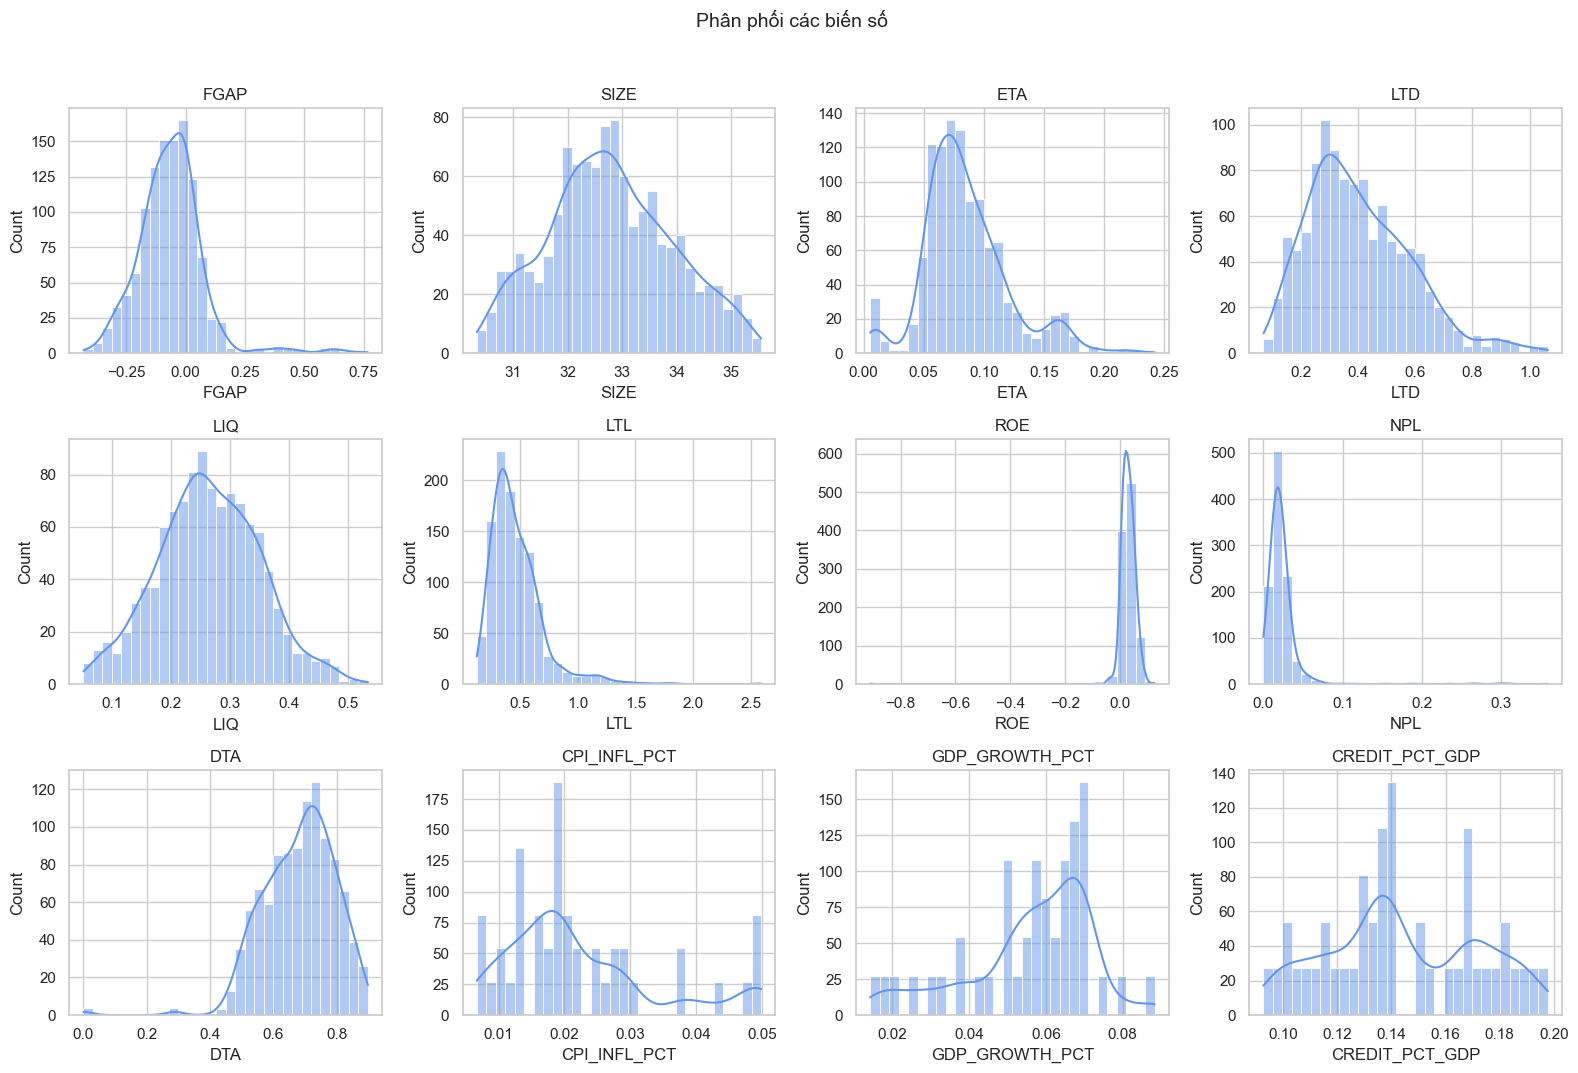

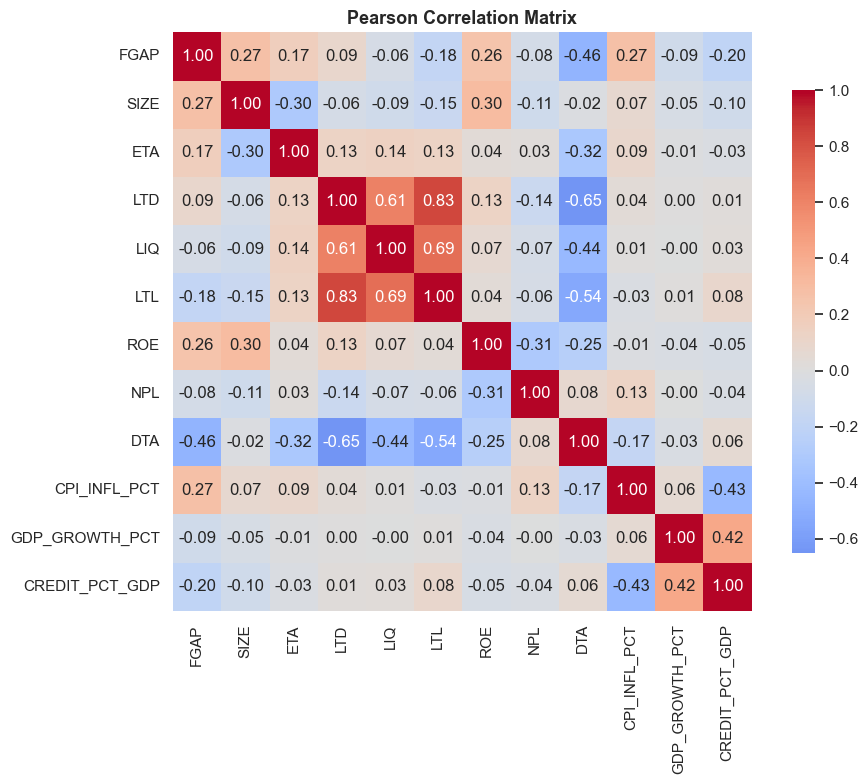

In [ ]:
# ===== EDA =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")

# === 1️⃣ Đọc ===
df = pd.read_csv("merge.csv")
df.columns = [c.strip().upper().replace(" ", "_") for c in df.columns]
print(f"Số dòng: {len(df):,} | Số cột: {df.shape[1]}")
print("Các cột hiện có:", list(df.columns))

# === 2️⃣ Loại bỏ các cột không cần thiết ===
exclude_cols = ["BANK_ID", "YEAR", "QUARTER", "NAM", "QUY"]
num_cols = [c for c in df.columns if c not in exclude_cols and np.issubdtype(df[c].dtype, np.number)]

print(f"\nSố biến số được phân tích: {len(num_cols)}")
print("Danh sách biến:", num_cols)

# === 3️⃣ Thống kê mô tả ===
desc = df[num_cols].describe().T[["mean","std","min","25%","50%","75%","max"]].round(3)
desc["missing_ratio"] = df[num_cols].isna().mean().round(3)
print("\nBảng thống kê mô tả (các biến số):")
display(desc)

# === 4️⃣ Phân phối tất cả biến số (Histogram + KDE) ===
n = len(num_cols)
n_cols = 4
n_rows = int(np.ceil(n / n_cols))

plt.figure(figsize=(16, 3.5 * n_rows))
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col].dropna(), kde=True, bins=30, color='cornflowerblue')
    plt.title(col)
plt.suptitle("Phân phối các biến số", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# === Ma trận tương quan ===
# === Ma trận tương quan có hiển thị giá trị ===
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử bạn đã có df và num_cols
corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",          # màu xanh–đỏ
    center=0,                 # trung tâm = 0
    annot=True,               # hiển thị giá trị tương quan
    fmt=".2f",                # hiển thị 2 chữ số thập phân
    square=True,              # ô vuông
    cbar_kws={"shrink": 0.8}  # thu nhỏ thanh màu
)
plt.title("Pearson Correlation Matrix", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()


DATA PROCESSING

In [ ]:
import pandas as pd
df = pd.read_csv("label.csv")
print(df.columns)


Index(['bank_id', 'year', 'quarter', 'FGAP', 'SIZE', 'ETA', 'LTD', 'LIQ',
       'LTL', 'ROE', 'NPL', 'DTA', 'CPI_INFL_PCT', 'GDP_GROWTH_PCT',
       'CREDIT_PCT_GDP', 'FGAP_stress_t+1'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np

def fill_missing_values_by_bank(df, bank_id_col='bank_id',
                                year_col='year', quarter_col='quarter',
                                interpolate_method='cubic'):
    """
    Điền giá trị thiếu cho từng ngân hàng (panel data):
    1️⃣ Nội suy cubic theo thời gian (year-quarter)
    2️⃣ Forward/Backward fill cho các giá trị biên
    """

    df = df.copy()

    # Tạo cột 'date' để sắp xếp đúng theo quý
    df['month'] = df[quarter_col] * 3
    df['date'] = pd.to_datetime(dict(year=df[year_col], month=df['month'], day=1)) + pd.offsets.MonthEnd(0)

    # Xác định các cột số cần nội suy
    numeric_cols = df.select_dtypes(include=['number']).columns.difference([year_col, quarter_col]).tolist()

    result = []

    for bank_id, group in df.groupby(bank_id_col):
        tmp = group.set_index('date').sort_index()

        # Tạo index đầy đủ theo quý trong phạm vi dữ liệu của bank
        full_idx = pd.date_range(start=tmp.index.min(), end=tmp.index.max(), freq='Q')
        tmp = tmp.reindex(full_idx)
        tmp[bank_id_col] = bank_id

        # Nội suy cubic cho từng cột
        for col in numeric_cols:
            tmp[col] = tmp[col].interpolate(method=interpolate_method, limit_direction='both')

        # Điền nốt phần biên
        tmp[numeric_cols] = tmp[numeric_cols].ffill().bfill()

        result.append(tmp)

    df_filled = pd.concat(result)
    df_filled.index.name = 'date'
    df_filled.reset_index(inplace=True)

    # Phục hồi lại cột thời gian
    df_filled['year'] = df_filled['date'].dt.year
    df_filled['quarter'] = df_filled['date'].dt.quarter

    # Xóa cột phụ
    df_filled.drop(columns=['month'], errors='ignore', inplace=True)

    print(f"[Imputation] Hoàn tất nội suy cubic và fill median cho {df[bank_id_col].nunique()} ngân hàng.")
    print("Top 10 cột còn NaN sau xử lý:")
    print(df_filled.isna().mean().sort_values(ascending=False).head(10))

    return df_filled


In [ ]:
df_filled = fill_missing_values_by_bank(df)

df_filled.to_csv("panel_clean.csv", index=False, encoding="utf-8-sig")


[Imputation] Hoàn tất nội suy cubic và fill median cho 27 ngân hàng.
Top 10 cột còn NaN sau xử lý:
date       0.0
bank_id    0.0
year       0.0
quarter    0.0
FGAP       0.0
SIZE       0.0
ETA        0.0
LTD        0.0
LIQ        0.0
LTL        0.0
dtype: float64


In [ ]:
# ===== PANEL PREPROCESSING (Time-aware IQR + Hybrid Scaling) =====
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer

# 1) Load & chuẩn hoá tên cột về UPPER
df = pd.read_csv("panel_clean.csv")
df.columns = [c.strip().upper() for c in df.columns]
print(f"Loaded panel_clean.csv | Rows: {len(df):,} | Cols: {df.shape[1]}")


# 2) Split theo thời gian (trước mọi fit để tránh leakage)
if 'YEAR' not in df.columns:
    raise ValueError("Missing YEAR column after standardization.")
train_df = df.query("(YEAR >= 2014) & (YEAR <= 2022)").copy()
test_df  = df.query("(YEAR >= 2023) & (YEAR <= 2024)").copy()

print(f"[Split] Train={len(train_df)} | Test={len(test_df)}")
print(f"Train period: {train_df['YEAR'].min()}–{train_df['YEAR'].max()} | "
      f"Test period: {test_df['YEAR'].min()}–{test_df['YEAR'].max()}")

# 3) Định nghĩa features & target (FGAP không nằm trong features)
features = [
    'SIZE','ETA','LIQ','LTD','ROE','NPL','DTA',
    'CREDIT_PCT_GDP','GDP_GROWTH_PCT','CPI_INFL_PCT'
]
target = 'FGAP_STRESS_T+1' if 'FGAP_STRESS_T+1' in df.columns else 'FGAP_STRESS_TP1'

# 4) IQR clipping trên TRAIN (micro only, không gồm FGAP), áp cho TRAIN & TEST
micro_cols = ['ETA','LIQ','LTD','ROE','NPL','DTA']  # FGAP bị loại vì là nguồn tạo nhãn
micro_cols = [c for c in micro_cols if c in train_df.columns]

def iqr_bounds(series, factor=1.5):
    q1 = series.quantile(0.25); q3 = series.quantile(0.75)
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        return None  # bỏ qua nếu biến phẳng trong train
    return q1 - factor*iqr, q3 + factor*iqr

iqr_thresholds = {}
for col in micro_cols:
    b = iqr_bounds(train_df[col].dropna(), factor=1.5)
    if b is not None:
        iqr_thresholds[col] = {'LOWER': b[0], 'UPPER': b[1]}

def apply_iqr_clip(df_in, thresholds):
    out = df_in.copy()
    for col, b in thresholds.items():
        if col in out.columns:
            out[col] = out[col].clip(b['LOWER'], b['UPPER'])
    return out

train_df = apply_iqr_clip(train_df, iqr_thresholds)
test_df  = apply_iqr_clip(test_df,  iqr_thresholds)
print(f" IQR clipping (fit on TRAIN) applied to: {list(iqr_thresholds.keys())}")

# 5) Chuẩn bị ma trận đặc trưng/nhãn
missing_in_train = [c for c in features + [target] if c not in train_df.columns]
if missing_in_train:
    raise KeyError(f"Các cột thiếu trong TRAIN: {missing_in_train}")

X_train = train_df[features].copy()
X_test  = test_df[features].copy()
y_train = train_df[target].astype(int).to_numpy()
y_test  = test_df[target].astype(int).to_numpy()

# Kiểm tra NaN trước scaler (Power/Standard/Robust không nhận NaN)
if X_train.isna().any().any() or X_test.isna().any().any():
    cols_with_nan = list(set(X_train.columns[X_train.isna().any()].tolist() + 
                             X_test.columns[X_test.isna().any()].tolist()))
    raise ValueError(f"Found NaN in features after preprocessing: {cols_with_nan}")

# 6) Hybrid scaling (fit on TRAIN → transform TEST)
standard_features = ['SIZE','CREDIT_PCT_GDP','GDP_GROWTH_PCT','CPI_INFL_PCT']
robust_features   = ['ETA','LIQ','LTD','NPL','DTA']  # vi mô dễ lệch/outlier
power_features    = ['ROE']  # Yeo-Johnson xử lý được âm/dương, đuôi lệch

# Bảo đảm mọi feature đều được gán scaler
defined = set(standard_features + robust_features + power_features)
missing_map = [f for f in features if f not in defined]
if missing_map:
    # An toàn: đưa phần thiếu vào robust
    robust_features += missing_map
    print(f"⚠️ Added to robust group by default: {missing_map}")

preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), [f for f in standard_features if f in features]),
        ('rob', RobustScaler(),   [f for f in robust_features   if f in features]),
        ('pwr', PowerTransformer(method='yeo-johnson'),
                                  [f for f in power_features    if f in features])
    ],
    remainder='drop',
    verbose_feature_names_out=False  # giữ tên cột gốc
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled  = preprocessor.transform(X_test)

print(" Applied hybrid scaling (fit on TRAIN)")
print("   - Standard:", [f for f in standard_features if f in features])
print("   - Robust   :", [f for f in robust_features   if f in features])
print("   - Power    :", [f for f in power_features    if f in features])

# 7) Lưu kết quả cuối cùng
train_out = pd.DataFrame(X_train_scaled, columns=preprocessor.get_feature_names_out())
train_out[target] = y_train

test_out = pd.DataFrame(X_test_scaled, columns=preprocessor.get_feature_names_out())
test_out[target] = y_test

train_out.to_csv("train_panel_processed.csv", index=False, encoding='utf-8-sig')
test_out.to_csv("test_panel_processed.csv",  index=False, encoding='utf-8-sig')

print(" Saved train_panel_processed.csv & test_panel_processed.csv")
print(f"[Shapes] X_train={X_train_scaled.shape}, X_test={X_test_scaled.shape}")
print(f"[Label balance] Train={y_train.mean():.3f}, Test={y_test.mean():.3f}")


Loaded panel_clean.csv | Rows: 1,134 | Cols: 17
[Split] Train=945 | Test=189
Train period: 2014–2022 | Test period: 2023–2024
 IQR clipping (fit on TRAIN) applied to: ['ETA', 'LIQ', 'LTD', 'ROE', 'NPL', 'DTA']
 Applied hybrid scaling (fit on TRAIN)
   - Standard: ['SIZE', 'CREDIT_PCT_GDP', 'GDP_GROWTH_PCT', 'CPI_INFL_PCT']
   - Robust   : ['ETA', 'LIQ', 'LTD', 'NPL', 'DTA']
   - Power    : ['ROE']
 Saved train_panel_processed.csv & test_panel_processed.csv
[Shapes] X_train=(945, 10), X_test=(189, 10)
[Label balance] Train=0.232, Test=0.439


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 1) Load datasets
train_df = pd.read_csv('train_panel_processed.csv')
test_df  = pd.read_csv('test_panel_processed.csv')

# 2) Separate features and target (assumes target column is named 'target')
target = 'FGAP_STRESS_T+1' if 'FGAP_STRESS_T+1' in train_df.columns else 'FGAP_STRESS_TP1'

# Separate features and target
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]
X_test = test_df.drop(target, axis=1)
y_test = test_df[target]


# 3) Unified sample weights for ALL models (equivalent ratio to XGBoost's scale_pos_weight)
#    spw = n_negative / n_positive
n_pos = int((y_train == 1).sum())
n_neg = int((y_train == 0).sum())
spw = n_neg / max(n_pos, 1)  # avoid division by zero
# Per-sample weights: class 0 -> 1.0, class 1 -> spw
sample_weight = np.where(y_train == 1, spw, 1.0)

print(f"Class counts -> 0: {n_neg}, 1: {n_pos}; scale_pos_weight (for ref): {spw:.4f}")

# 4) Define models (NO class_weight / scale_pos_weight here; we use sample_weight during fit)
models = {
    'Logistic Regression': (
        LogisticRegression(
            max_iter=2000,
            solver='liblinear',   # supports l1 & l2
            random_state=42
        ),
        {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    ),
    'Random Forest': (
        RandomForestClassifier(
            random_state=42
        ),
        {
            'n_estimators': [200, 500, 800],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    ),
    'XGBoost': (
        XGBClassifier(
            # We omit scale_pos_weight intentionally to rely on sample_weight for fairness
            eval_metric='logloss',
            tree_method='hist',
            random_state=42,
            n_jobs=-1
        ),
        {
            'n_estimators': [200, 400, 800],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.03, 0.1, 0.3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'reg_lambda': [1, 5, 10],   # L2 regularization
            'reg_alpha': [0, 0.5, 1],   # L1 regularization
            }
        )
    }

# 5) Stratified CV to preserve class ratio in folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6) Run GridSearchCV for each model with the SAME sample_weight input
results = {}

for name, (model, params) in models.items():
    print(f"=== Running GridSearchCV for {name} ===")
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        verbose=1,
        refit=True
    )

    # Pass per-sample weights so all models see the same weighting
    grid.fit(X_train, y_train, **{'sample_weight': sample_weight})

    best_model = grid.best_estimator_
    print(f"Best Params for {name}: {grid.best_params_}")

    # Evaluate on test set
    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= 0.5).astype(int)

    # Compute ROC AUC and a threshold-optimized version (Youden's J)
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, thr = roc_curve(y_test, y_proba)
    opt_idx = np.argmax(tpr - fpr)
    opt_thr = thr[opt_idx]
    y_pred_opt = (y_proba >= opt_thr).astype(int)

    res = {
        'Best Params': grid.best_params_,
        'ROC AUC (0.5 thr)': auc,
        'Classification Report (0.5 thr)': classification_report(y_test, y_pred),
        'Confusion Matrix (0.5 thr)': confusion_matrix(y_test, y_pred),
        'Optimal Threshold': float(opt_thr),
        'Classification Report (opt thr)': classification_report(y_test, y_pred_opt),
        'Confusion Matrix (opt thr)': confusion_matrix(y_test, y_pred_opt)
    }
    results[name] = res

# 7) Display results
for name, res in results.items():
    print(f"================ {name} ================")
    print(f"Best Params: {res['Best Params']}")
    print(f"ROC AUC (0.5 thr): {res['ROC AUC (0.5 thr)']:.4f}")
    print("Classification Report (0.5 thr):", res['Classification Report (0.5 thr)'])
    print("Confusion Matrix (0.5 thr):", res['Confusion Matrix (0.5 thr)'])
    print(f"Optimal Threshold: {res['Optimal Threshold']:.4f}")
    print("Classification Report (opt thr):", res['Classification Report (opt thr)'])
    print("Confusion Matrix (opt thr):", res['Confusion Matrix (opt thr)'])

# 8) TYPE I & TYPE II ERROR ANALYSIS + COST-SENSITIVE THRESHOLDING
# Type I error (False Positive): predict 1 but true 0
# Type II error (False Negative): predict 0 but true 1

from dataclasses import dataclass

@dataclass
class ErrMetrics:
    threshold: float
    fp: int
    fn: int
    tp: int
    tn: int
    type1_rate: float  # FPR = FP / (FP + TN)
    type2_rate: float  # FNR = FN / (FN + TP)


def compute_err_metrics(y_true, y_proba, thr):
    from sklearn.metrics import confusion_matrix
    y_pred = (y_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    type1_rate = fp / max(fp + tn, 1)
    type2_rate = fn / max(fn + tp, 1)
    return ErrMetrics(threshold=float(thr), fp=int(fp), fn=int(fn), tp=int(tp), tn=int(tn),
                      type1_rate=float(type1_rate), type2_rate=float(type2_rate))


def search_threshold_min_cost(y_true, y_proba, cost_fp=1.0, cost_fn=1.0, n_grid=1000):
    # Sweep thresholds on sorted unique probabilities (or linspace as fallback)
    import numpy as np
    uniq = np.unique(y_proba)
    if len(uniq) > n_grid:
        grid = np.linspace(0.0, 1.0, n_grid)
    else:
        grid = uniq
    best = None
    best_cost = float('inf')
    for thr in grid:
        em = compute_err_metrics(y_true, y_proba, thr)
        cost = cost_fp * em.type1_rate + cost_fn * em.type2_rate
        if cost < best_cost:
            best_cost = cost
            best = (thr, em)
    return best  # (threshold, ErrMetrics)

# Collect y_true and y_proba for each model to analyze Type I/II
# Re-run predictions with stored best estimators to keep memory light
summary_rows = []

for name, (model, params) in models.items():
    # Fit again on the whole train set using best params found above (refit=True already done)
    # We'll reuse the already refitted estimator via GridSearchCV if available.
    # For simplicity, re-create GridSearchCV to fetch best estimator from 'results' context.
    # But we already have metrics in 'results'; let's recompute probabilities with the best estimator by re-training:
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        verbose=0,
        refit=True
    )
    grid.fit(X_train, y_train, **{'sample_weight': sample_weight})
    best_est = grid.best_estimator_
    y_proba = best_est.predict_proba(X_test)[:, 1]

    # 8a) Metrics at default 0.5 threshold
    em_05 = compute_err_metrics(y_test, y_proba, 0.5)

    # 8b) Metrics at Youden's J optimal threshold
    fpr, tpr, thr = roc_curve(y_test, y_proba)
    opt_idx = np.argmax(tpr - fpr)
    opt_thr = thr[opt_idx]
    em_opt = compute_err_metrics(y_test, y_proba, opt_thr)

    # 8c) Cost-sensitive threshold to reduce Type I vs Type II
    COST_FP = 1.0  # <--- chỉnh nếu muốn phạt FP mạnh hơn
    COST_FN = 1.0  # <--- chỉnh nếu muốn phạt FN mạnh hơn
    thr_cs, em_cs = search_threshold_min_cost(y_test, y_proba, COST_FP, COST_FN)

    # Save compact summary row
    summary_rows.append({
        'Model': name,
        'Thr@0.5': 0.5,
        'Type I rate@0.5 (FPR)': round(em_05.type1_rate, 4),
        'Type II rate@0.5 (FNR)': round(em_05.type2_rate, 4),
        'Thr@Youden': round(float(opt_thr), 4),
        'Type I rate@Youden': round(em_opt.type1_rate, 4),
        'Type II rate@Youden': round(em_opt.type2_rate, 4),
        'Thr@CostSensitive': round(float(thr_cs), 4),
        'Type I rate@CS': round(em_cs.type1_rate, 4),
        'Type II rate@CS': round(em_cs.type2_rate, 4)
    })

# 9) Print a consolidated table of thresholds and Type I/II rates
try:
    import pandas as pd
    summary_df = pd.DataFrame(summary_rows)
    print("===== Threshold & Error Summary (Type I/II) =====")
    print(summary_df.to_string(index=False))
except Exception as e:
    print("Could not render summary table:", e)

# 10) Also print the BEST PARAMS of all models in one place for convenience
print("===== Best Params (recomputed here for display) =====")
for name, (model, params) in models.items():
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        verbose=0,
        refit=True
    )
    grid.fit(X_train, y_train, **{'sample_weight': sample_weight})
    print(f"{name}: {grid.best_params_}")


Class counts -> 0: 726, 1: 219; scale_pos_weight (for ref): 3.3151
=== Running GridSearchCV for Logistic Regression ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params for Logistic Regression: {'C': 10, 'penalty': 'l1'}
=== Running GridSearchCV for Random Forest ===
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params for Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
=== Running GridSearchCV for XGBoost ===
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Params for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 400, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
================ Logistic Regression ================
Best Params: {'C': 10, 'penalty': 'l1'}
ROC AUC (0.5 thr): 0.8822
Classification Report (0.5 thr):               precision    recall  f1-score   support

           0       0.96     

In [ ]:
# Giả sử bạn cũng có các model huấn luyện tên là:
fitted_models = {
    'LR': results['Logistic Regression'],
    'DT': results['Random Forest'],   # hoặc 'Decision Tree' nếu bạn dùng cây quyết định
    'SVM': results['XGBoost']         # ví dụ minh họa
}

# Vẽ ROC và Confusion Matrix theo mẫu
plt.figure(figsize=(10, 12))
for i, (name, res) in enumerate(fitted_models.items()):
    # ROC
    plt.subplot(len(fitted_models), 2, 2*i + 1)
    y_pred_proba = res['y_proba'] if 'y_proba' in res else None  # hoặc tính lại nếu chưa lưu
    if y_pred_proba is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC={auc_score:.3f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f"{name} ROC Curve")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc='lower right')

    # Confusion matrix
    plt.subplot(len(fitted_models), 2, 2*i + 2)
    cm = res['Confusion Matrix (0.5 thr)']
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=[0,1], yticklabels=[0,1])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

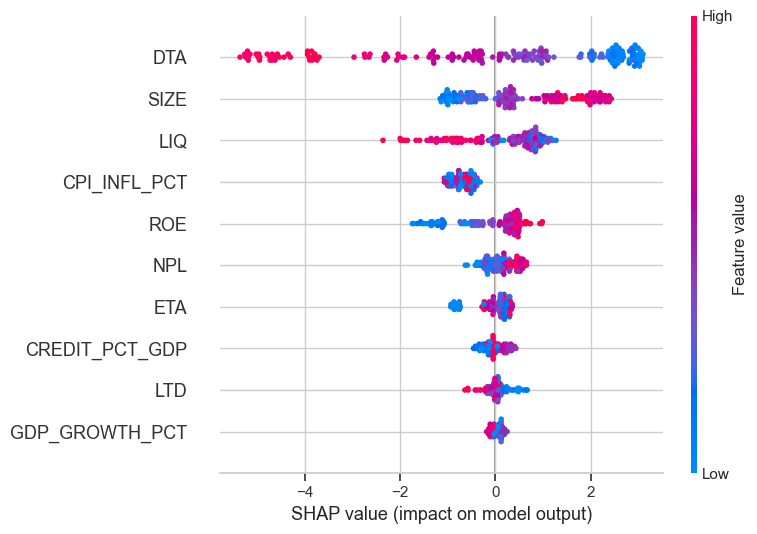

 TOP 6 BIẾN QUAN TRỌNG NHẤT THEO SHAP:
1. DTA                  | Importance: 2.1920 | Index: 8
2. SIZE                 | Importance: 1.0031 | Index: 0
3. LIQ                  | Importance: 0.7405 | Index: 5
4. CPI_INFL_PCT         | Importance: 0.6899 | Index: 3
5. ROE                  | Importance: 0.5633 | Index: 9
6. NPL                  | Importance: 0.2547 | Index: 7

 CHỌN BIẾN CHO PDP/ICE THEO 2 TIÊU CHÍ:
- Financial Ratios: ['DTA', 'LIQ', 'ROE', 'NPL']
- Macro Factors: ['CPI_INFL_PCT']

 FINAL SELECTION - 5 biến:
   1. DTA (index: 8)
   2. LIQ (index: 5)
   3. ROE (index: 9)
   4. NPL (index: 7)
   5. CPI_INFL_PCT (index: 3)


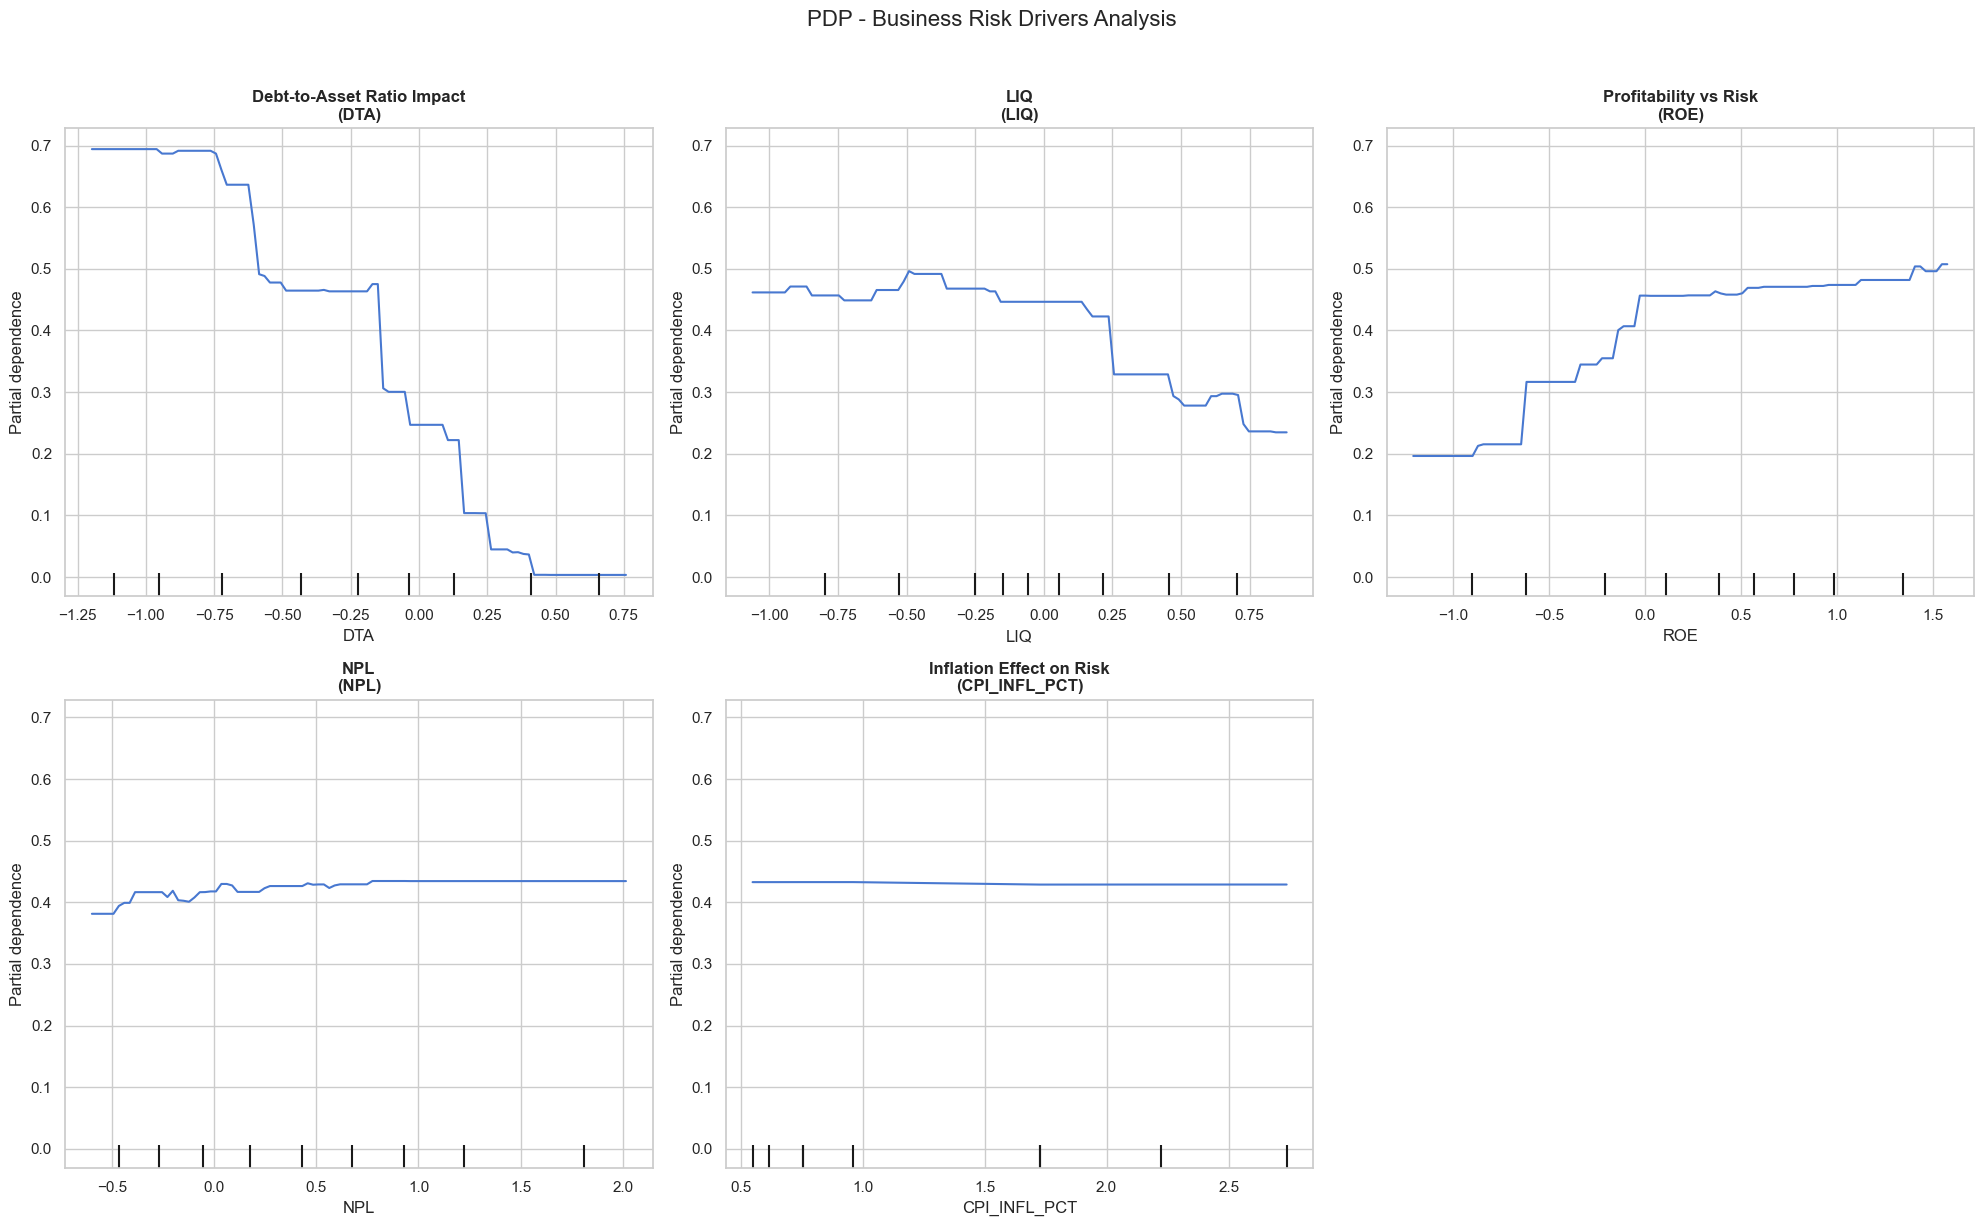

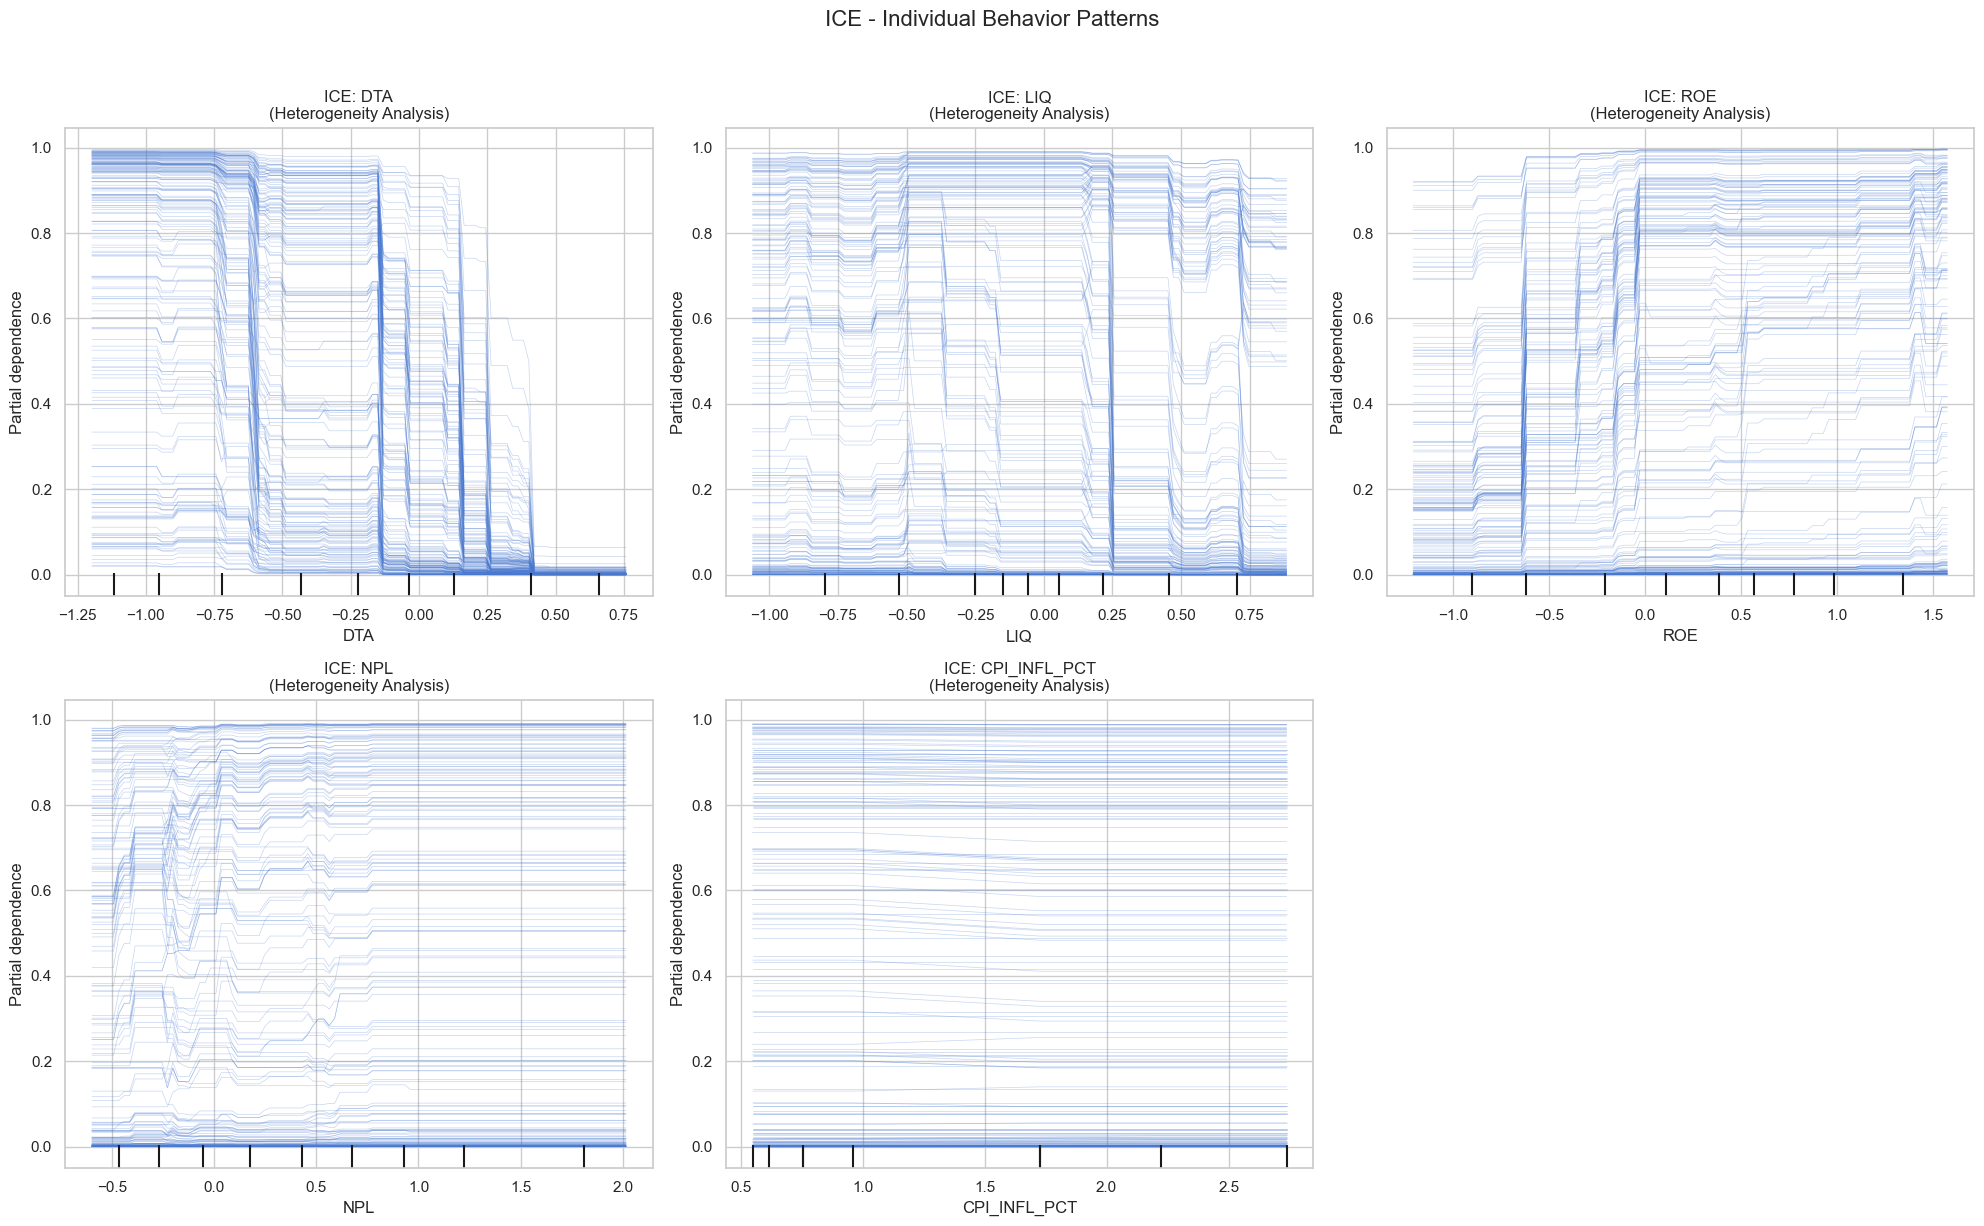

In [ ]:
# using SHAP
best_params = {
    'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3,
    'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 1.0
}
xgb_clf = XGBClassifier(
    **best_params,
    random_state=42,
    tree_method="hist",
    enable_categorical=False,
    n_jobs=-1
)
xgb_clf.fit(X_train, y_train)    

X_te = X_test

xgb_explainer = shap.TreeExplainer(xgb_clf)
xgb_shap_values = xgb_explainer.shap_values(X_te)

# 1. SHAP ANALYSIS - TÌM BIẾN QUAN TRỌNG
shap.summary_plot(xgb_shap_values, X_te, feature_names=X_te.columns.tolist())

# TÍNH TOÁN FEATURE IMPORTANCE
feature_importance = np.abs(xgb_shap_values).mean(0)
top_indices = np.argsort(feature_importance)[-6:][::-1]

print(" TOP 6 BIẾN QUAN TRỌNG NHẤT THEO SHAP:")
top_features = []
for i, idx in enumerate(top_indices):
    feature_name = X_te.columns[idx]
    importance_val = feature_importance[idx]
    top_features.append(feature_name)
    print(f"{i+1}. {feature_name:20s} | Importance: {importance_val:.4f} | Index: {idx}")

# 2. BUSINESS-DRIVEN SELECTION (QUAN TRỌNG!)
print("\n CHỌN BIẾN CHO PDP/ICE THEO 2 TIÊU CHÍ:")

# Nhóm biến theo domain knowledge
financial_ratios = [f for f in top_features if f in ['DTA', 'LTL', 'ROE', 'ETA', 'NPL', 'LIQ']]
macro_factors = [f for f in top_features if f in ['CPI_INFL_PCT', 'CREDIT_PCT_GDP', 'GDP_GROWTH_PCT']]

print(f"- Financial Ratios: {financial_ratios}")
print(f"- Macro Factors: {macro_factors}")

# Đảm bảo cân bằng giữa 2 nhóm
selected_features = []
selected_features.extend(financial_ratios[:4])  # Lấy top 4 financial
selected_features.extend(macro_factors[:2])     # Lấy top 2 macro

# Map tên biến sang index
feature_index = [X_te.columns.get_loc(f) for f in selected_features]

print(f"\n FINAL SELECTION - {len(selected_features)} biến:")
for i, (name, idx) in enumerate(zip(selected_features, feature_index)):
    print(f"   {i+1}. {name} (index: {idx})")

# 3. PDP + ICE VỚI BUSINESS INTERPRETATION
# PDP Plot
fig_pdp, ax_pdp = plt.subplots(ncols=3, nrows=2, figsize=(20, 12))
ax_pdp_flat = ax_pdp.flatten()

PartialDependenceDisplay.from_estimator(
    xgb_clf, X_te, 
    features=feature_index, 
    ax=ax_pdp_flat[:len(feature_index)]
)

# Thêm business context vào title
business_titles = {
    'DTA': "Debt-to-Asset Ratio Impact",
    'LTL': "Long-Term Liabilities Risk", 
    'ROE': "Profitability vs Risk",
    'CPI_INFL_PCT': "Inflation Effect on Risk"
}

for i, (ax, feat_idx) in enumerate(zip(ax_pdp_flat, feature_index)):
    feat_name = X_te.columns[feat_idx]
    title = business_titles.get(feat_name, feat_name)
    ax.set_title(f"{title}\n({feat_name})", fontsize=12, fontweight='bold')

# Ẩn axes không dùng
for i in range(len(feature_index), len(ax_pdp_flat)):
    ax_pdp_flat[i].set_visible(False)

plt.suptitle("PDP - Business Risk Drivers Analysis", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# ICE Plot với focus vào heterogeneity 
fig_ice, ax_ice = plt.subplots(ncols=3, nrows=2, figsize=(20, 12))
ax_ice_flat = ax_ice.flatten()

PartialDependenceDisplay.from_estimator(
    xgb_clf, X_te, 
    features=feature_index, 
    ax=ax_ice_flat[:len(feature_index)],
    kind='individual'
)

for i, (ax, feat_idx) in enumerate(zip(ax_ice_flat, feature_index)):
    feat_name = X_te.columns[feat_idx]
    ax.set_title(f"ICE: {feat_name}\n(Heterogeneity Analysis)", fontsize=12)

for i in range(len(feature_index), len(ax_ice_flat)):
    ax_ice_flat[i].set_visible(False)

plt.suptitle("ICE - Individual Behavior Patterns", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



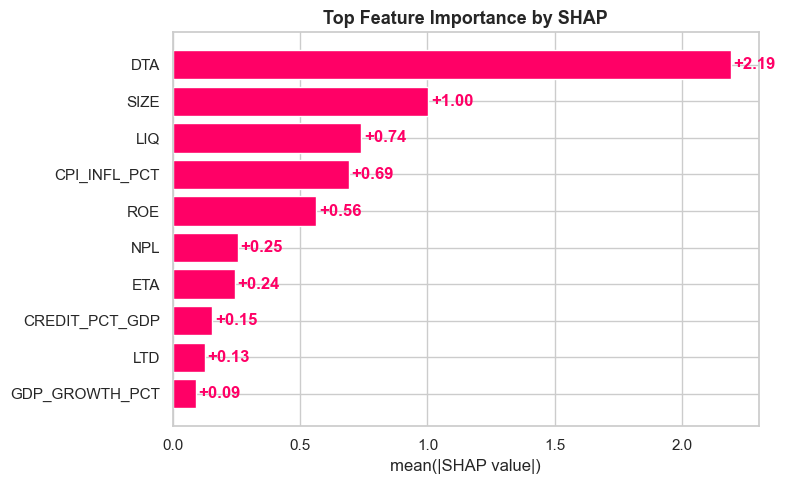

In [ ]:
# === SHAP BAR PLOT ===
import matplotlib.pyplot as plt
import numpy as np

# 1. Tính giá trị tuyệt đối trung bình của SHAP cho từng biến
feature_importance = np.abs(xgb_shap_values).mean(0)
feature_names = X_te.columns.tolist()

# 2. Sắp xếp giảm dần
sorted_idx = np.argsort(feature_importance)[::-1]
top_n = 10  # có thể đổi thành 8 hoặc 12 tùy bạn
top_features = [feature_names[i] for i in sorted_idx[:top_n]]
top_values = feature_importance[sorted_idx[:top_n]]

# 3. Vẽ biểu đồ thanh ngang
plt.figure(figsize=(8, 5))
bars = plt.barh(top_features[::-1], top_values[::-1], color="#FF0066")
plt.xlabel("mean(|SHAP value|)", fontsize=12)
plt.title("Top Feature Importance by SHAP", fontsize=13, fontweight="bold")

# 4. Gắn nhãn + giá trị ở cuối mỗi thanh
for i, v in enumerate(top_values[::-1]):
    plt.text(v + 0.01, i, f"+{v:.2f}", color="#FF0066", fontweight="bold", va="center")

plt.tight_layout()
plt.show()
